# Objectives

In this notebook, we work to implement the local fitting scheme but fetching the true vertical locations at the preset x-locations and working with them, only performing a local fit at the end to get the node's final vertical position once its horizontal displacement has been identified.

The easiest way to do this is to choose x-nodes for which the waveform fetching function can directly give the corresponding vertical position; this requires us to put x-nodes on whole numbers between 0 and 576 rather than a numpy.linspace application to preset the x-nodes.

In [1]:
import numpy as np
import utils
import evolutionTools as evt
import cv2
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def place_x_nodes(interval, n_nodes):
    start, end = interval
    N = n_nodes
    if N == 1:
        return [start]
    elif N == 2:
        return [start, end]
    
    step = (end - start) // (N - 1)
    
    # Generate nodes
    nodes = [start + i * step for i in range(N)]
    
    # Ensure the last element is exactly the end
    nodes[-1] = end
    
    return np.array(nodes)

In [3]:
place_x_nodes((0, 575), 50)

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 297, 308, 319, 330, 341, 352, 363, 374, 385, 396, 407, 418,
       429, 440, 451, 462, 473, 484, 495, 506, 517, 528, 575])

We now tweak the waveform-fetching function to avoid fitting before solving for the unknown displacements.

In [4]:
def get_upper_waveform(video_name, image_number, OUTPUT = False):   #no path - just number
    image_path = "Data/video"+video_name+"_TREATED/"+"image"+ str(image_number) +".jpg"
    frame = cv2.imread(image_path)
    frame = utils.image_processing(frame) #To get two dimensional array instead of 3 (Grayscale)
    
    waveform = utils.get_waveform(frame) #Upper and Lower surfaces
    upper_surface = waveform[:, 0]

    #plt.plot(np.arange(utils.width), middle_line, label = "middle")     # CAN CHANGE
    #plt.show()
    
    return upper_surface

We now tweak all functions that depend on this function to generate displacements and resultant potentials.

In [5]:
def get_frame_potential(video_name, image_number, initial_lengths, K_arr, initial_guess = np.zeros(evt.N), x_nodes = None):
    
    waveform = get_upper_waveform(video_name, image_number)
    x_nodes = place_x_nodes((0,575), evt.N) if x_nodes is None else x_nodes
    y_nodes = waveform[x_nodes]

#     plt.figure()
#     plt.plot(x_nodes,y_nodes)
#     plt.show()
    
    displacements = minimize(evt.potentialEnergy, initial_guess, args = (x_nodes, y_nodes, initial_lengths, K_arr))
    
#     print(displacements.x)
#   this is where the local fit is required
# for now ill leave the approximation with the slope lol
#

    U_pot = evt.potentialEnergy(displacements.x, x_nodes, y_nodes, initial_lengths, K_arr)
    
#     plt.figure(figsize=(8,6))
#     plt.plot(x_nodes[1:-1], displacements.x)
#     plt.title(f"Fram: {imageNumber}")
#     plt.show()
    
    
    return U_pot, displacements.x

For now the above function doesn't fit anything at all, but instead computes the resultant energy by using the extrapolation scheme that yields the displacements in the first place.

In [6]:
def potential_evolution(video_name, total_images, increment = 1):   #returns Potential Array (Chronological)
    
    image_number = 1
    
    # First, get the initial lengths and stiffnesses.
    
    x_nodes = place_x_nodes((0, 575), evt.N +  2)
    
    waveform = get_upper_waveform(video_name, image_number, False)

    y_nodes = waveform[x_nodes]
    
    initial_lengths = evt.initialLengthsFinder(x_nodes, y_nodes)
    K_arr = np.ones(evt.N+1)/(initial_lengths*1000)
    
    # Iterate over images and record potential
    
    U_arr = np.zeros(total_images)
    initial_guess = np.zeros(evt.N)
    #print(initial_lengths)
    displacements = []
    
    while image_number <= total_images:
        
        print(f'Processing Frame: {image_number}')
        U, new_guess = get_frame_potential(video_name, image_number, initial_lengths, K_arr, initial_guess, x_nodes)
        displacements.append(new_guess)
        U_arr[image_number - 1] = U
        image_number += increment
        initial_guess = new_guess
    
    return U_arr, displacements

In [7]:
energy, displacements = potential_evolution('003HA_Right_20160129_110735.avi', 139, 1)
displacements = np.array(displacements)

Processing Frame: 1
Processing Frame: 2
Processing Frame: 3
Processing Frame: 4
Processing Frame: 5
Processing Frame: 6
Processing Frame: 7
Processing Frame: 8
Processing Frame: 9
Processing Frame: 10
Processing Frame: 11
Processing Frame: 12
Processing Frame: 13
Processing Frame: 14
Processing Frame: 15
Processing Frame: 16
Processing Frame: 17
Processing Frame: 18
Processing Frame: 19
Processing Frame: 20
Processing Frame: 21
Processing Frame: 22
Processing Frame: 23
Processing Frame: 24
Processing Frame: 25
Processing Frame: 26
Processing Frame: 27
Processing Frame: 28
Processing Frame: 29
Processing Frame: 30
Processing Frame: 31
Processing Frame: 32
Processing Frame: 33
Processing Frame: 34
Processing Frame: 35
Processing Frame: 36
Processing Frame: 37
Processing Frame: 38
Processing Frame: 39
Processing Frame: 40
Processing Frame: 41
Processing Frame: 42
Processing Frame: 43
Processing Frame: 44
Processing Frame: 45
Processing Frame: 46
Processing Frame: 47
Processing Frame: 48
P

In [8]:
example_data_displacement = pd.DataFrame(displacements) # type: ignore

In [9]:
example_data_displacement.to_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_displacements.csv', index = False)

In [10]:
example_data_energy = pd.DataFrame(energy) # type: ignore

In [11]:
example_data_energy.to_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_energy.csv', index = False)

In [12]:
displacements = pd.read_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_displacements.csv').to_numpy()
energy = pd.read_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_energy.csv').to_numpy()

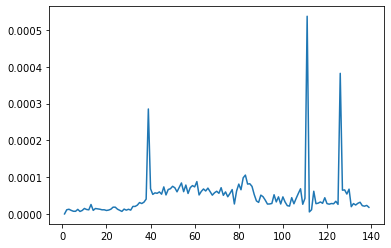

In [13]:
plt.figure()
plt.plot(np.arange(1,140), energy)
plt.show()

We unfortunately still observe some singularities and noise. We can try to instead perform a local fit to retrieve the node's vertical position rather than the linear extrapolation. Since we've already fetched the displacements, we must only fit and recompute the energy using the newly determined horizontal position of the nodes.

In [14]:
def compute_frame_energy(video_name, image_number, displacements, initial_lengths, K_arr, x_nodes = None):
    
    waveform = get_upper_waveform(video_name, image_number)
    x_nodes = place_x_nodes((0,575), evt.N + 2) if x_nodes is None else x_nodes
    y_nodes = waveform[x_nodes]

#     plt.figure()
#     plt.plot(x_nodes,y_nodes)
#     plt.show()

    new_x_positions = deepcopy(x_nodes)
    for i in range(1, new_x_positions.shape[0] - 1):
        new_x_positions[i] += displacements[i-1]
    new_y_nodes = np.zeros(new_x_positions.shape[0])
    for index in range(new_y_nodes.shape[0]):
        min_index = max([i - 5, 0])
        max_index = min([i+5, x_nodes[-1]])
        coefficients = np.polyfit(x_nodes[min_index:max_index], y_nodes[min_index:max_index], 4)
        new_y_nodes[i] = coefficients[0] * new_x_positions[i]**4
        new_y_nodes[i] += coefficients[1] * new_x_positions[i] ** 3
        new_y_nodes[i] += coefficients[2] * new_x_positions[i] ** 2
        new_y_nodes[i] += coefficients[3] * new_x_positions[i] ** 2
        new_y_nodes[i] += coefficients[4] 
    
#     print(displacements.x)
#   this is where the local fit is required
# for now ill leave the approximation with the slope lol
    def poten(x_0, y_i, lengths, K):
    
        segmentEnergies = np.zeros(evt.N+1)        #To sum at the end
        x = x_0
        y = y_i
            
        for i in range(K.shape[0]):
            
            
            p1 = (x[i], y[i])
            p2 = (x[i+1], y[i+1])
            
            newDist = evt.euclideanDistance(p1, p2)
            
            segmentEnergies[i] = 0.5 * K[i] * (newDist - lengths[i])**2
        
        return np.sum(segmentEnergies)

    U_pot = poten(x_nodes, y_nodes, initial_lengths, K_arr)
    
#     plt.figure(figsize=(8,6))
#     plt.plot(x_nodes[1:-1], displacements.x)
#     plt.title(f"Fram: {imageNumber}")
#     plt.show()
    
    
    return U_pot, new_y_nodes

In [15]:
def compute_energy_evolution(video_name, total_images, displacements, increment = 1):   #returns Potential Array (Chronological)
    
    image_number = 1
    
    # First, get the initial lengths and stiffnesses.
    
    x_nodes = place_x_nodes((0, 575), evt.N +  2)
    
    waveform = get_upper_waveform(video_name, image_number, False)

    y_nodes = waveform[x_nodes]
    
    initial_lengths = evt.initialLengthsFinder(x_nodes, y_nodes)
    K_arr = np.ones(evt.N+1)/(initial_lengths* 1000)
    
    # Iterate over images and record potential
    
    U_arr = np.zeros(total_images)
    new_y_nodes = []

    # print(initial_lengths)
    
    while image_number <= total_images:
        
        print(f'Processing Frame: {image_number}')
        U, y_disp = compute_frame_energy(video_name, image_number, displacements[image_number-1], initial_lengths, K_arr, x_nodes)
        new_y_nodes.append(y_disp)
        U_arr[image_number - 1] = U
        image_number += increment
    
    return U_arr, np.array(new_y_nodes)

In [16]:
adjusted_energy, new_y_nodes = compute_energy_evolution('003HA_Right_20160129_110735.avi', 139, displacements, 1)

Processing Frame: 1
Processing Frame: 2
Processing Frame: 3
Processing Frame: 4
Processing Frame: 5
Processing Frame: 6
Processing Frame: 7
Processing Frame: 8
Processing Frame: 9
Processing Frame: 10
Processing Frame: 11
Processing Frame: 12
Processing Frame: 13
Processing Frame: 14
Processing Frame: 15
Processing Frame: 16
Processing Frame: 17
Processing Frame: 18
Processing Frame: 19
Processing Frame: 20
Processing Frame: 21
Processing Frame: 22
Processing Frame: 23
Processing Frame: 24
Processing Frame: 25
Processing Frame: 26
Processing Frame: 27
Processing Frame: 28
Processing Frame: 29
Processing Frame: 30
Processing Frame: 31
Processing Frame: 32
Processing Frame: 33
Processing Frame: 34
Processing Frame: 35
Processing Frame: 36
Processing Frame: 37
Processing Frame: 38
Processing Frame: 39
Processing Frame: 40
Processing Frame: 41
Processing Frame: 42
Processing Frame: 43
Processing Frame: 44
Processing Frame: 45
Processing Frame: 46
Processing Frame: 47
Processing Frame: 48
P

In [17]:
adjusted_energy_df = pd.DataFrame(adjusted_energy)
adjusted_energy_df.to_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_adjusted_energy.csv', index = False)
new_y_df = pd.DataFrame(new_y_nodes)
new_y_df.to_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_new_vertical_positions.csv', index = False)

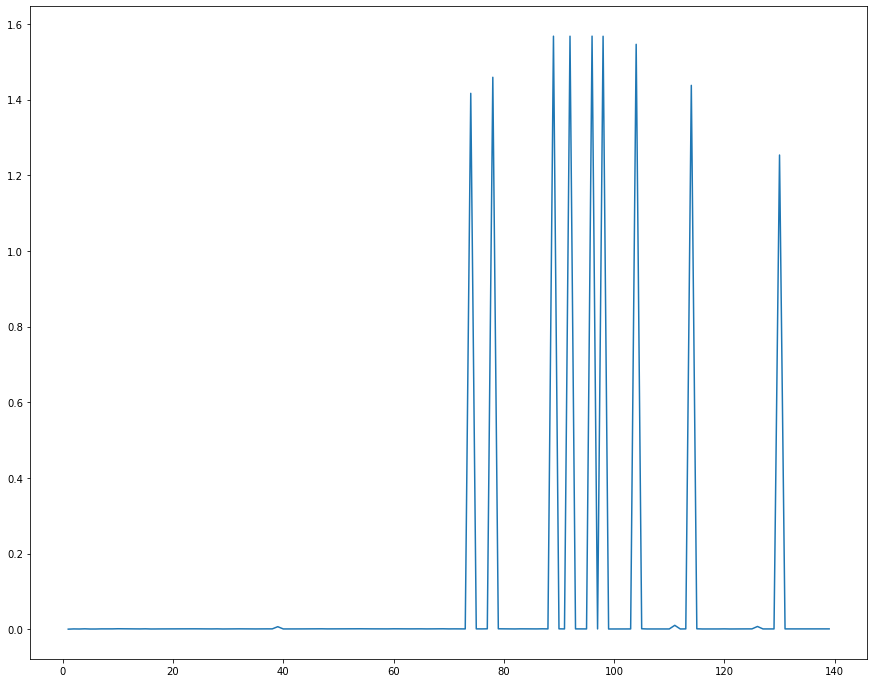

In [18]:
plt.figure(figsize = (15,12))
plt.plot(np.arange(1,140), adjusted_energy)
plt.show()